In [8]:
#!pip install openeo
#!pip install rasterio

!pip install matplotlib

     |████████████████████████████████| 7.6 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 256 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 3.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/krzysztofpraca/Projects/hackathon-2023/venv/bin/python3 -m pip install --upgrade pip' command.


In [126]:
import openeo
import rasterio
import numpy as np
from matplotlib import pyplot as plt

from openeo.processes import ProcessBuilder

In [51]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [123]:
# Load data cube from TERRASCOPE_S2_NDVI_V2 collection.
cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent={"west": 20.95, "south": 52.05, "east": 21.05, "north": 52.15},
    temporal_extent=["2023-05-01", "2023-07-30"],
    bands=['oainfon'],
)

evi_aggregation = cube.aggregate_spatial(
    reducer="mean",
)

evi_aggregation.download("processed.tiff")

ValueError: Invalid band name/index 'oainfon'. Valid names: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'WVP', 'AOT', 'SCL', 'sunAzimuthAngles', 'sunZenithAngles', 'viewAzimuthMean', 'viewZenithMean']

In [53]:
with rasterio.open('ndvi-max.tiff') as fp:
    img = fp.read()

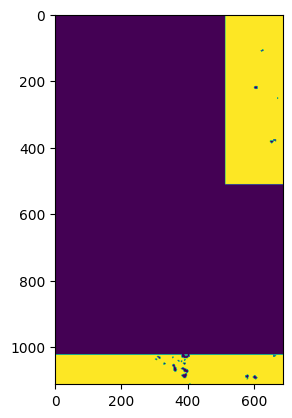

In [54]:
plt.imshow(np.moveaxis(img, [0, 1, 2], [2, 0, 1]) / img.max())

In [50]:
img.shape

(1, 1113, 686)

In [125]:
cube.apply?

Signature:
cube.apply(
    process: 'Union[str, typing.Callable, UDF, PGNode]',
    context: 'Optional[dict]' = None,
) -> 'DataCube'
Docstring:
Applies a unary process (a local operation) to each value of the specified or all dimensions in the data cube.

:param process: the "child callback":
    the name of a single process,
    or a callback function as discussed in :ref:`callbackfunctions`,
    or a :py:class:`UDF <openeo.rest._datacube.UDF>` instance.

    The callback should correspond to a process that
    receives a single numerical value
    and returns a single numerical value.
    For example:

    -   ``"absolute"`` (string)
    -   :py:func:`absolute <openeo.processes.absolute>` (:ref:`predefined openEO process function <openeo_processes_functions>`)
    -   ``lambda x: x * 2 + 3`` (function or lambda)

:param context: Additional data to be passed to the process.

:return: A data cube with the newly computed values. The resolution, cardinality and the number of dimensions 

In [129]:
ProcessBuilder?

Init signature:
ProcessBuilder(
    pgnode: Union[openeo.internal.graph_building.PGNode, dict, list],
)
Docstring:      .. include:: api-processbuilder.rst
File:           ~/Projects/hackathon-2023/venv/lib/python3.10/site-packages/openeo/processes.py
Type:           ABCMeta
Subclasses:     

In [56]:
connection.load_collection?

Signature:
connection.load_collection(
    collection_id: 'Union[str, Parameter]',
    spatial_extent: 'Optional[Dict[str, float]]' = None,
    temporal_extent: 'Union[Sequence[InputDate], Parameter, str, None]' = None,
    bands: 'Union[None, List[str], Parameter]' = None,
    properties: 'Optional[Dict[str, Union[str, PGNode, Callable]]]' = None,
    max_cloud_cover: 'Optional[float]' = None,
    fetch_metadata=True,
) -> 'DataCube'
Docstring:
Load a DataCube by collection id.

:param collection_id: image collection identifier
:param spatial_extent: limit data to specified bounding box or polygons
:param temporal_extent: limit data to specified temporal interval.
    Typically, just a two-item list or tuple containing start and end date.
    See :ref:`filtering-on-temporal-extent-section` for more details on temporal extent handling and shorthand notation.
:param bands: only add the specified bands
:param properties: limit data by metadata property predicates
:param max_cloud_cover: 

In [62]:
class City:
    def __init__(self, name, lat, lng):
        self.name = name
        self.lat = lat
        self.lng = lng

    def get_spatial_extent(self, radius=0.2):
        spatial_extent = {
            "west": self.lng-radius, 
            "south": self.lat-radius, 
            "east": self.lng+radius, 
            "north": self.lat+radius
        }
        return spatial_extent

    def get_features(self, radius=0.15):
        features = {
            "type": "FeatureCollection", 
            "features": [
                {
                    "type": "Feature", 
                    "properties": {},
                    "geometry": {
                        "type": "Polygon", 
                        "coordinates": [
                            [
                                [self.lat - radius, self.lng - radius], 
                                [self.lat + radius, self.lng - radius], 
                                [self.lat + radius, self.lng + radius], 
                                [self.lat - radius, self.lng + radius], 
                                [self.lat - radius, self.lng - radius]
                            ]
                        ]
                    }
                }
            ]
        }
        return features

In [63]:
warsaw = City('Madrid', 52, 21)

In [78]:
madrid = {
    "west": -3.73,
    "south": 40.39,
    "east": -3.67,
    "north": 40.43
}

In [83]:
(madrid['east']+madrid['west']) / 2

-3.7

In [84]:
(madrid['north']+madrid['south'])/2

40.41

In [85]:
madrid = City('Madrid', 40.41, -3.7)

In [90]:
# Load data cube from TERRASCOPE_S2_NDVI_V2 collection.
cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=madrid.get_spatial_extent(0.08),
    temporal_extent=["2023-07-01", "2023-07-31"],
    bands=['B04', 'B08'],
)

parsed = cube.aggregate_spatial(
    geometries=madrid.get_features(0.05),
    reducer="mean",
)

In [99]:
x = cube.band('B04') - cube.band('B08')

In [110]:
new_cube = cube.add_dimension(name='Water', label='water', type='band')

In [120]:
cube_with_ndvi = cube.ndvi(red='B04', nir='B08', target_band='ndvi')

In [122]:
results = cube_with_ndvi.execute_batch()

Preflight process graph validation raised: [MissingProduct] Tile 'S2B_MSIL2A_20230702T105629_N0509_R094_T30TVK_20230702T122952' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230705T110629_N0509_R137_T30TVK_20230705T123921' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230707T105621_N0509_R094_T30TVK_20230707T171859' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230710T110621_N0509_R137_T30TVK_20230710T172204' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230712T105629_N0509_R094_T30TVK_20230712T123126' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230715T110629_N0509_R137_T30TVK_20230715T124001' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230717T105621_N0509_R094_T30TVK_20230717T185600' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A

0:00:00 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': send 'start'
0:00:13 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:00:18 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:00:25 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:00:33 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:00:43 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:00:55 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:01:11 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:01:30 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:01:59 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': running (progress N/A)
0:02:30 Job 'j-231103ff63e84430bd5a0198e4a3d3e6': finished (progress N/A)


In [101]:
x.execute_batch()

Preflight process graph validation raised: [MissingProduct] Tile 'S2B_MSIL2A_20230702T105629_N0509_R094_T30TVK_20230702T122952' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230705T110629_N0509_R137_T30TVK_20230705T123921' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230707T105621_N0509_R094_T30TVK_20230707T171859' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230710T110621_N0509_R137_T30TVK_20230710T172204' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230712T105629_N0509_R094_T30TVK_20230712T123126' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230715T110629_N0509_R137_T30TVK_20230715T124001' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230717T105621_N0509_R094_T30TVK_20230717T185600' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A

0:00:00 Job 'j-231103ffc9304993bd56446921e88290': send 'start'
0:00:12 Job 'j-231103ffc9304993bd56446921e88290': created (progress N/A)
0:00:18 Job 'j-231103ffc9304993bd56446921e88290': created (progress N/A)
0:00:24 Job 'j-231103ffc9304993bd56446921e88290': running (progress N/A)
0:00:32 Job 'j-231103ffc9304993bd56446921e88290': running (progress N/A)
0:00:43 Job 'j-231103ffc9304993bd56446921e88290': running (progress N/A)
0:00:55 Job 'j-231103ffc9304993bd56446921e88290': running (progress N/A)
0:01:11 Job 'j-231103ffc9304993bd56446921e88290': running (progress N/A)
0:01:30 Job 'j-231103ffc9304993bd56446921e88290': running (progress N/A)
0:01:54 Job 'j-231103ffc9304993bd56446921e88290': running (progress N/A)
0:02:25 Job 'j-231103ffc9304993bd56446921e88290': finished (progress N/A)


<BatchJob job_id='j-231103ffc9304993bd56446921e88290'>

In [88]:
madrid_results = parsed.execute()

Preflight process graph validation raised: [MissingProduct] Tile 'S2B_MSIL2A_20230702T105629_N0509_R094_T30TVK_20230702T122952' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230705T110629_N0509_R137_T30TVK_20230705T123921' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230707T105621_N0509_R094_T30TVK_20230707T171859' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2A_MSIL2A_20230710T110621_N0509_R137_T30TVK_20230710T172204' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230712T105629_N0509_R094_T30TVK_20230712T123126' in collection 'SENTINEL2_L2A' is not available. [MissingProduct] Tile 'S2B_MSIL2A_20230715T110629_N0509_R137_T30TVK_20230715T124001' in collection 'SENTINEL2_L2A' is not available.


In [89]:
madrid_results

{'2023-07-01T00:00:00Z': [[3487.606751654448, 3525.6488922465014]],
 '2023-07-04T00:00:00Z': [[4689.041479068917, 4747.299653754793]],
 '2023-07-06T00:00:00Z': [[294.2996304189796, 266.8675803482743]],
 '2023-07-09T00:00:00Z': [[2859.123396883836, 2827.095230087254]],
 '2023-07-11T00:00:00Z': [[443.6249245710865, 403.2478323118861]],
 '2023-07-14T00:00:00Z': [[6166.877248330871, 6003.755467915797]]}

In [92]:
cube.aggregate_spatial?

Signature:
cube.aggregate_spatial(
    geometries: 'Union[shapely.geometry.base.BaseGeometry, dict, str, pathlib.Path, Parameter, VectorCube]',
    reducer: 'Union[str, typing.Callable, PGNode]',
    target_dimension: 'Optional[str]' = None,
    crs: 'Optional[Union[int, str]]' = None,
    context: 'Optional[dict]' = None,
) -> 'VectorCube'
Docstring:
Aggregates statistics for one or more geometries (e.g. zonal statistics for polygons)
over the spatial dimensions.

:param geometries: a shapely geometry, a GeoJSON-style dictionary,
    a public GeoJSON URL, or a path (that is valid for the back-end) to a GeoJSON file.
:param reducer: the "child callback":
    the name of a single openEO process,
    or a callback function as discussed in :ref:`callbackfunctions`,
    or a :py:class:`UDF <openeo.rest._datacube.UDF>` instance.

    The callback should correspond to a process that
    receives an array of numerical values
    and returns a single numerical value.
    For example:

    -   

In [ ]:
plt.imshow(np.moveaxis(img, [0, 1, 2], [2, 0, 1]) / img.max())